# Question 1
## Is there a difference in the number of Covid-19 cases between Blue and Red States in the US?

In [350]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, make_scorer, accuracy_score, precision_score, f1_score, recall_score


In [351]:
# Ignore any warning
import warnings
warnings.filterwarnings('ignore')

### Hypothesis Testing

In [352]:
# Hypothesis Testing: Is there a difference in the number of Covid-19 cases between blue and red states?
# Null Hypothesis: There is no difference in the mean of number of Covid-19 cases between blue and red states. 

# Load Data
covid_cases = pd.read_csv('./datasets/covid-cases-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv') 
factors = pd.read_csv('./datasets/covid-state-data-agg/COVID19_state.csv')
red_blue = pd.read_csv('./datasets/BlueRedStates.csv')

# Merge factors data with red_blue data
factors = factors.merge(red_blue, left_on='State', right_on='stateName')

# Gather only covid cases in the year 2020
covid_cases['submission_date'] = pd.to_datetime(covid_cases.submission_date, format='%m/%d/%Y')
stateCases2020 = covid_cases[covid_cases['submission_date'].dt.year == 2020]

# Create 2 dataframes one on blue states and the other on red states 
blueCode = red_blue[red_blue['BlueRed'] == 'B'].stateCode
redCode = red_blue[red_blue['BlueRed'] == 'R'].stateCode

In [353]:
# 8625 blue entries
blueStates = stateCases2020[stateCases2020['state'].isin(blueCode)]
NYC = stateCases2020[stateCases2020['state'] == 'NYC']['new_case'].sum()

blueStatesTot = blueStates.groupby('state')['new_case'].sum()
blueStatesTot['NY'] = blueStatesTot['NY'] + NYC 
blueStatesPop = factors[factors['stateCode'].isin(blueCode)]['Population']
blueStates = pd.DataFrame({'state code': blueStatesTot.index, 'total cases': blueStatesTot.values, 'population': blueStatesPop})

# Normalize each state by its population
blueStates['case ratio'] = blueStates['total cases'] / blueStates['population']

In [355]:
# 8280 red entries
redStates = stateCases2020[stateCases2020['state'].isin(redCode)]

redStatesTot = redStates.groupby('state')['new_case'].sum()
redStatesPop = factors[factors['stateCode'].isin(redCode)]['Population']
redStates = pd.DataFrame({'state code': redStatesTot.index, 'total cases': redStatesTot.values, 'population': redStatesPop})

# Normalize each state by its population
redStates['case ratio'] = redStates['total cases'] / redStates['population']

### Plot Case Ratios by States

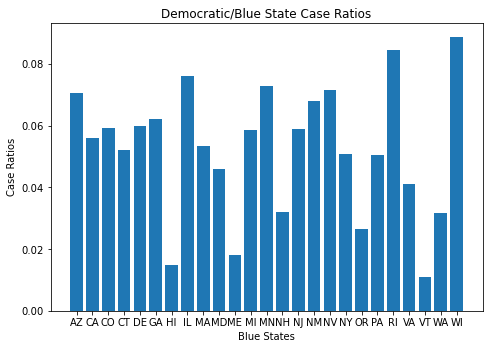

   state code  total cases  population  case ratio
3          AZ     520559.0     7378494    0.070551
4          CA    2231552.0    39937489    0.055876
5          CO     347198.0     5845526    0.059396
6          CT     185708.0     3563077    0.052120
7          DE      58847.0      982895    0.059871
9          GA     666452.0    10736059    0.062076
10         HI      21026.0     1412687    0.014884
13         IL     963389.0    12659682    0.076099
18         MA     373473.0     6976597    0.053532
19         MD     280219.0     6083116    0.046065
20         ME      24201.0     1345790    0.017983
21         MI     589728.0    10045029    0.058708
22         MN     415302.0     5700671    0.072851
29         NH      44028.0     1371246    0.032108
30         NJ     527784.0     8936574    0.059059
31         NM     142864.0     2096640    0.068139
32         NV     224731.0     3139658    0.071578
33         NY     990626.0    19440469    0.050957
36         OR     113909.0     

In [356]:
# Plot Blue State Case Ratios
#plt.plot(blueStates['state code'], blueStates['case ratio'], '-o')
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
ax.bar(blueStates['state code'], blueStates['case ratio'])
plt.title('Democratic/Blue State Case Ratios')
plt.xlabel('Blue States')
plt.ylabel('Case Ratios')
plt.show()
print(blueStates)

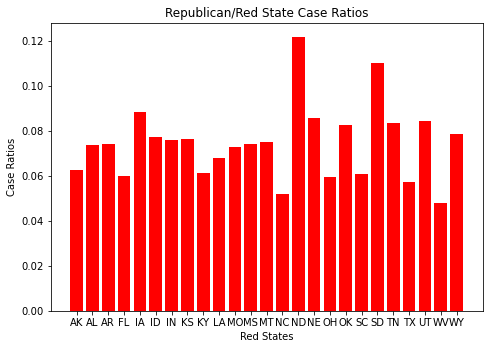

   state code  total cases  population  case ratio
0          AK      45771.0      734002    0.062358
1          AL     362094.0     4908621    0.073767
2          AR     225138.0     3038999    0.074083
8          FL    1318256.0    21992985    0.059940
11         IA     280669.0     3179849    0.088265
12         ID     141077.0     1826156    0.077254
14         IN     511698.0     6745354    0.075859
15         KS     222433.0     2910357    0.076428
16         KY     275530.0     4499692    0.061233
17         LA     315275.0     4645184    0.067871
23         MO     449569.0     6169270    0.072872
24         MS     221928.0     2989260    0.074242
25         MT      81555.0     1086759    0.075044
26         NC     550145.0    10611862    0.051842
27         ND      92770.0      761723    0.121790
28         NE     167233.0     1952570    0.085648
34         OH     700380.0    11747694    0.059619
35         OK     325524.0     3954821    0.082311
39         SC     317350.0     

In [357]:
# Plot Red State Case Ratios
#plt.plot(redStates['state code'], redStates['case ratio'], '-ro')
fig = plt.figure(2)
ax = fig.add_axes([0,0,1,1])
ax.bar(redStates['state code'], redStates['case ratio'], color = 'r')
plt.title('Republican/Red State Case Ratios')
plt.xlabel('Red States')
plt.ylabel('Case Ratios')
plt.show()
print(redStates)

### Independent t-test

In [358]:
# Run an independent t-test on the two populations/groups to check whether or not there is a difference in their means 
stats.ttest_ind(blueStates['case ratio'], redStates['case ratio'])
#the p-value < 0.05 

Ttest_indResult(statistic=-4.086588191517973, pvalue=0.00016557577918043718)

# Question 2
## Can we classify Red vs Blue States based on Covid-19 cases and other state-specific metadata?

### Data Cleaning and Feature Selection

In [360]:
# Load data
covid_cases = pd.read_csv('./datasets/covid-cases-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
factors = pd.read_csv('./datasets/covid-state-data-agg/COVID19_state.csv')
red_blue = pd.read_csv('./BlueRedStates.csv')
trips = pd.read_csv('./datasets/bts-travel-data/State_trips.csv')

In [361]:
# covid_cases.head()
covid_cases['submission_date'] = pd.to_datetime(covid_cases['submission_date'])
covid_cases = covid_cases.sort_values(by='submission_date', ascending = True)

# Select rows for 2020 only
covid_cases2 = covid_cases.loc[(covid_cases['submission_date'] < '2021-01-01')]

# Group by each state and sum new_cases
tot_cases = covid_cases2.groupby('state').sum()[['new_case']]

# Agreggate NYC into NY
tot_cases['new_case']['NY'] = sum(tot_cases.loc['NYC'], tot_cases.loc['NY'])

In [362]:
# Merge BlueRed State with tot_cases data
BR_totcases = tot_cases.merge(red_blue, left_on='state', right_on='stateCode')

# Merge BR_totcases with factors data
factors_BR_totcases = BR_totcases.merge(factors, left_on='stateName', right_on='State')

# Normalize cases for each state
factors_BR_totcases['Case Rates'] = factors_BR_totcases['new_case']/factors_BR_totcases['Population']

# Select for 2020 data only
trips['Date'] = pd.to_datetime(trips['Date'])
trips2 = trips.loc[((trips['Date'] < '2021-01-01') & (trips['Date'] > '2019-12-31'))]

In [363]:
# Replace all commas with none
trips2['Number of Trips'].replace(',','', regex=True, inplace=True)

# Make the columns numeric
trips2['Number of Trips'] = trips2['Number of Trips'].apply(pd.to_numeric,errors='coerce')

# Group by each state and sum the number of trips
trips3 = trips2.groupby('State Postal Code').sum()[['Number of Trips']]

In [365]:
# Merge factors_BR_totcases with trips aggregate data into final data table
final_data = factors_BR_totcases.merge(trips3, left_on='stateCode', right_on='State Postal Code')
final_data['Travel Rates'] = final_data['Number of Trips']/final_data['Population']

# Set stateCode as index
final_data.set_index('stateCode',inplace=True)

In [366]:
# Select relevant columns for analysis
clean_data = final_data.drop(columns = ['new_case','stateName','State','Tested','Infected','Deaths','Pop Density',
                                        'Flu Deaths','Respiratory Deaths','School Closure Date', 'Number of Trips'])
clean_data.corr()

,Population,Gini,ICU Beds,Income,GDP,Unemployment,Sex Ratio,Smoking Rate,Physicians,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,Case Rates,Travel Rates
Population,1.000000,0.489153,0.977777,0.209982,0.239292,0.056601,-0.231239,-0.253963,0.950090,0.871706,-0.192039,0.614910,0.926917,0.357940,0.449917,0.041088,0.439364,-0.286929,-0.132673,-0.182759
Gini,0.489153,1.000000,0.525640,0.039587,-0.031954,0.209380,-0.666283,0.149586,0.552587,0.409587,-0.081117,0.353152,0.359948,0.506835,0.178469,-0.233470,0.188732,0.139431,-0.065060,0.159023
ICU Beds,0.977777,0.525640,1.000000,0.126107,0.153102,0.065429,-0.286387,-0.132029,0.927856,0.888210,-0.211876,0.614208,0.915420,0.410413,0.422019,0.040795,0.397757,-0.251051,-0.090235,-0.144079
Income,0.209982,0.039587,0.126107,1.000000,0.886935,-0.122642,0.113816,-0.578860,0.353439,-0.024489,0.535438,-0.117286,0.194902,-0.361070,0.459420,-0.321554,0.488891,0.002390,-0.260566,0.276087
GDP,0.239292,-0.031954,0.153102,0.886935,1.000000,-0.076271,0.181340,-0.519444,0.370516,0.052185,0.501020,-0.044363,0.215272,-0.343662,0.510665,-0.118241,0.527030,-0.197398,-0.108380,0.249295
Unemployment,0.056601,0.209380,0.065429,-0.122642,-0.076271,1.000000,-0.050725,0.435496,0.088856,0.092155,0.147367,0.307559,0.050503,0.008140,-0.029129,0.021113,0.001858,-0.051017,-0.019041,-0.069488
Sex Ratio,-0.231239,-0.666283,-0.286387,0.113816,0.181340,-0.050725,1.000000,-0.124306,-0.277989,-0.171933,0.116936,-0.330909,-0.134672,-0.675553,-0.123240,0.330431,-0.071815,-0.275038,0.312873,-0.164675
Smoking Rate,-0.253963,0.149586,-0.132029,-0.578860,-0.519444,0.435496,-0.124306,1.000000,-0.275156,-0.026140,0.051128,-0.041518,-0.274076,0.124497,-0.606205,0.031118,-0.337320,0.196889,0.212825,0.079043
Physicians,0.950090,0.552587,0.927856,0.353439,0.370516,0.088856,-0.277989,-0.275156,1.000000,0.769297,-0.028213,0.560669,0.850339,0.236641,0.479681,-0.057781,0.450284,-0.201409,-0.167838,-0.024783
Hospitals,0.871706,0.409587,0.888210,-0.024489,0.052185,0.092155,-0.171933,-0.026140,0.769297,1.000000,-0.275708,0.539095,0.778483,0.387575,0.266901,0.230479,0.264597,-0.368739,0.037703,-0.168371


In [367]:
# Drop Population column as well
clean_data = clean_data.drop(columns = ['Population'])
clean_data.corr()

,Gini,ICU Beds,Income,GDP,Unemployment,Sex Ratio,Smoking Rate,Physicians,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,Case Rates,Travel Rates
Gini,1.000000,0.525640,0.039587,-0.031954,0.209380,-0.666283,0.149586,0.552587,0.409587,-0.081117,0.353152,0.359948,0.506835,0.178469,-0.233470,0.188732,0.139431,-0.065060,0.159023
ICU Beds,0.525640,1.000000,0.126107,0.153102,0.065429,-0.286387,-0.132029,0.927856,0.888210,-0.211876,0.614208,0.915420,0.410413,0.422019,0.040795,0.397757,-0.251051,-0.090235,-0.144079
Income,0.039587,0.126107,1.000000,0.886935,-0.122642,0.113816,-0.578860,0.353439,-0.024489,0.535438,-0.117286,0.194902,-0.361070,0.459420,-0.321554,0.488891,0.002390,-0.260566,0.276087
GDP,-0.031954,0.153102,0.886935,1.000000,-0.076271,0.181340,-0.519444,0.370516,0.052185,0.501020,-0.044363,0.215272,-0.343662,0.510665,-0.118241,0.527030,-0.197398,-0.108380,0.249295
Unemployment,0.209380,0.065429,-0.122642,-0.076271,1.000000,-0.050725,0.435496,0.088856,0.092155,0.147367,0.307559,0.050503,0.008140,-0.029129,0.021113,0.001858,-0.051017,-0.019041,-0.069488
Sex Ratio,-0.666283,-0.286387,0.113816,0.181340,-0.050725,1.000000,-0.124306,-0.277989,-0.171933,0.116936,-0.330909,-0.134672,-0.675553,-0.123240,0.330431,-0.071815,-0.275038,0.312873,-0.164675
Smoking Rate,0.149586,-0.132029,-0.578860,-0.519444,0.435496,-0.124306,1.000000,-0.275156,-0.026140,0.051128,-0.041518,-0.274076,0.124497,-0.606205,0.031118,-0.337320,0.196889,0.212825,0.079043
Physicians,0.552587,0.927856,0.353439,0.370516,0.088856,-0.277989,-0.275156,1.000000,0.769297,-0.028213,0.560669,0.850339,0.236641,0.479681,-0.057781,0.450284,-0.201409,-0.167838,-0.024783
Hospitals,0.409587,0.888210,-0.024489,0.052185,0.092155,-0.171933,-0.026140,0.769297,1.000000,-0.275708,0.539095,0.778483,0.387575,0.266901,0.230479,0.264597,-0.368739,0.037703,-0.168371
Health Spending,-0.081117,-0.211876,0.535438,0.501020,0.147367,0.116936,0.051128,-0.028213,-0.275708,1.000000,-0.377795,-0.171802,-0.559658,-0.200392,-0.511958,-0.000621,0.457156,-0.150237,0.326204


### Classification Model and Evaluation

**Feature Selection for Logistic Regression**

In [368]:
# Select Predictors and Outcome Variable
X = clean_data.copy().drop(columns = 'BlueRed')
Y = clean_data['BlueRed']

# Convert 'B/R' to 1/0
Y_num = []
for idx in range(0, Y.size):
    if Y[idx] == 'B':
        Y_num.append(1)
    else:
        Y_num.append(0)       
Y_num = np.array(Y_num)

# Select best features and fit model to train set
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, Y)
coefs = selector.estimator_.coef_
thresh = selector.threshold_
support = selector.get_support()
X_selected = selector.transform(X)

# Run regression
logistic = LogisticRegression(penalty='l1',solver='liblinear', random_state=1)

**Plot the beta coefficients for features**

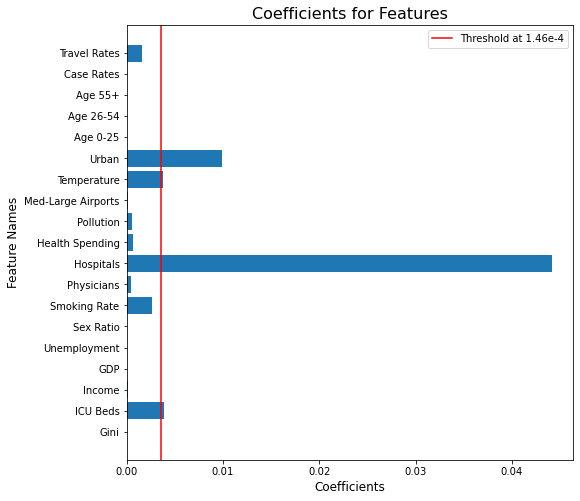

In [369]:
# Plot the betas
feature_names = X.columns
importance = abs(coefs.T[:,0])
plt.figure(figsize = (8,8))
plt.barh(np.linspace(1,len(importance),len(importance)),importance,
         tick_label=feature_names) 
plt.axvline(x=thresh, color = 'r', label = 'Threshold at 1.46e-4')
plt.title('Coefficients for Features', size = 16)
plt.xlabel('Coefficients', size = 12)
plt.ylabel('Feature Names', size = 12)
plt.legend()
plt.show()

In [370]:
# View selected features from final model
selected_features = []
for idx in range(0, len(X.columns)):
    if support[idx]:
        selected_features.append(X.columns[idx])
print('Selected Features:', selected_features)

Selected Features: ['ICU Beds', 'Hospitals', 'Temperature', 'Urban']


### Evaluation Method 1: Accuracy, Precision, Recall, F1-Score
**Comparison of Model Performances - Logistic Regression, Random Forest, SVM**

In [371]:
# Define dictionary with performance metrics
scoring = {'accuracy': make_scorer(accuracy_score), 
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score), 
           'f1_score': make_scorer(f1_score)}

# Initiate the classifiers
logistic = LogisticRegression()
forest = RandomForestClassifier(n_estimators = 100)
clf = svm.SVC(probability=True)

# Define the models evaluation function
def models_evaluation(x_selected, x, y, folds):
    # x: features
    # y: target labels
    # folds: number of cross-validation folds
    
    # Perform cross-validation to each machine learning classifier
    logisticM = cross_validate(logistic, X_selected, y, cv=folds, scoring=scoring)
    forestM = cross_validate(forest, x, y, cv=folds, scoring=scoring)
    clfM = cross_validate(clf, x, y, cv=folds, scoring=scoring)

    # Create a dataframe with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[logisticM['test_accuracy'].mean(),
                                                 logisticM['test_precision'].mean(),
                                                 logisticM['test_recall'].mean(),
                                                 logisticM['test_f1_score'].mean()],
                                       
                                       'Random Forest':[forestM['test_accuracy'].mean(),
                                                       forestM['test_precision'].mean(),
                                                       forestM['test_recall'].mean(),
                                                       forestM['test_f1_score'].mean()],
                                       
                                      'SVM':[clfM['test_accuracy'].mean(),
                                             clfM['test_precision'].mean(),
                                             clfM['test_recall'].mean(),
                                             clfM['test_f1_score'].mean()]},
                                                
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
 
# Run models_evaluation function
models_evaluation(X_selected, X, Y_num, 10)

,Logistic Regression,Random Forest,SVM,Best Score
Accuracy,0.720000,0.800000,0.660000,Random Forest
Precision,0.783333,0.841667,0.750000,Random Forest
Recall,0.700000,0.816667,0.583333,Random Forest
F1 Score,0.700000,0.805714,0.620000,Random Forest


### Evaluation Method 2: ROC-AUC, Confusion Matrix

**Logistic Regression Model**

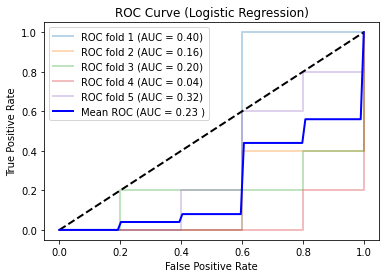

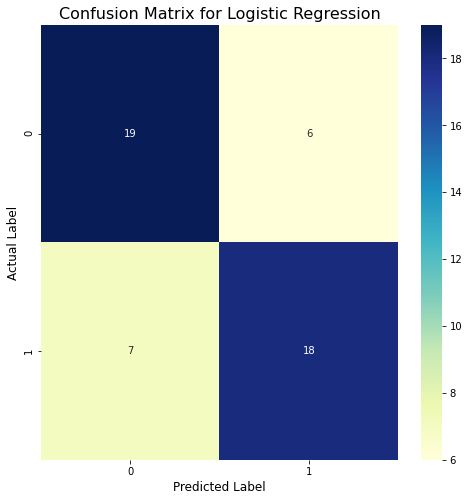

In [372]:
# Cross-validation for training/testing
cv = StratifiedKFold(n_splits=5,shuffle=False)

# Initialize arrays for True positive rates and AUC scores
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1   

# Initialize confusion matrix
confusion = np.zeros([2,2])

# Perform cross validation, compute auc and confusion matrix values
for train,test in cv.split(X_selected,Y):
    prediction = logistic.fit(X_selected[train],Y[train]).predict_proba(X_selected[test])
    fpr, tpr, t = roc_curve(Y_num[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    Y_pred = logistic.predict(X_selected[test])
    Y_test = Y[test]
    conf_temp = metrics.confusion_matrix(Y_test, Y_pred)
    confusion += conf_temp
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

# Plot ROC-AUC curve
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc="best")
plt.show()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize = [8,8])
sns.heatmap(confusion, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix for Logistic Regression', size = 16)
plt.xlabel('Predicted Label', size = 12)
plt.ylabel('Actual Label', size = 12)
plt.show()

**Random Forest Model**

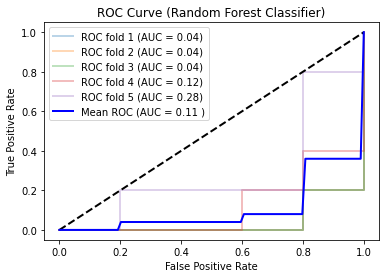

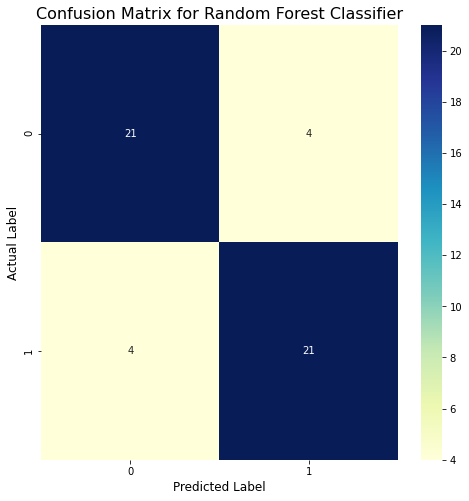

In [373]:
# Convert df to np.array
X = np.array(X)
Y = np.array(Y)

# Initialize arrays for True positive rates and AUC scores
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1   

# Initialize confusion matrix
confusion = np.zeros([2,2])

# Perform cross validation, compute auc and confusion matrix values
for train,test in cv.split(X,Y):
    prediction = forest.fit(X[train],Y[train]).predict_proba(X[test])
    fpr, tpr, t = roc_curve(Y_num[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    Y_pred = forest.predict(X[test])
    Y_test = Y[test]
    conf_temp = metrics.confusion_matrix(Y_test, Y_pred)
    confusion += conf_temp
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

# Plot ROC-AUC curve
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest Classifier)')
plt.legend(loc="best")
plt.show()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize = [8,8])
sns.heatmap(confusion, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix for Random Forest Classifier', size = 16)
plt.xlabel('Predicted Label', size = 12)
plt.ylabel('Actual Label', size = 12)
plt.show()

**SVM Model**

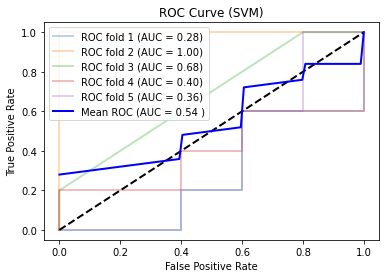

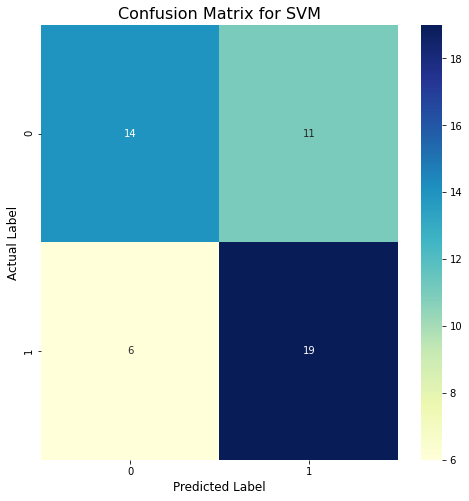

In [374]:
# Initialize arrays for True positive rates and AUC scores
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1   

# Initialize confusion matrix
confusion = np.zeros([2,2])

# Perform cross validation, compute auc and confusion matrix values
for train,test in cv.split(X,Y):
    prediction = clf.fit(X[train],Y[train]).predict_proba(X[test])
    fpr, tpr, t = roc_curve(Y_num[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    Y_pred = clf.predict(X[test])
    Y_test = Y[test]
    conf_temp = metrics.confusion_matrix(Y_test, Y_pred)
    confusion += conf_temp
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

# Plot ROC-AUC curve
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend(loc="best")
plt.show()

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize = [8,8])
sns.heatmap(confusion, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix for SVM', size = 16)
plt.xlabel('Predicted Label', size = 12)
plt.ylabel('Actual Label', size = 12)
plt.show()